In [8]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'nearest'
import matplotlib.pyplot as plt
import numpy as np

## Exercise: Going interplanetary

The sun is one of the most spherical objects in our solar system.
According to an [article in Scientific American](http://www.scientificamerican.com/gallery/well-rounded-sun-stays-nearly-spherical-even-when-it-freaks-out/):

> Earth's closest star is one of the roundest objects humans have
> measured. If you shrank the sun down to beach ball size, the
> difference between its north-south and the east-west diameters would
> be thinner than the width of a human hair, says Jeffery Kuhn, a
> physicist and solar researcher at the University of Hawaii at
> Manoa. "Not only is it very round, but it's too round," he adds. The
> sun is more spherical and more invariable than theories predict.

If the sun is spherical, we should be able to fit a circle to a 2D
slice of it!  Your task is to do just that, using RANSAC and scikit-image's CircleModel.

Let's start by loading an example image:

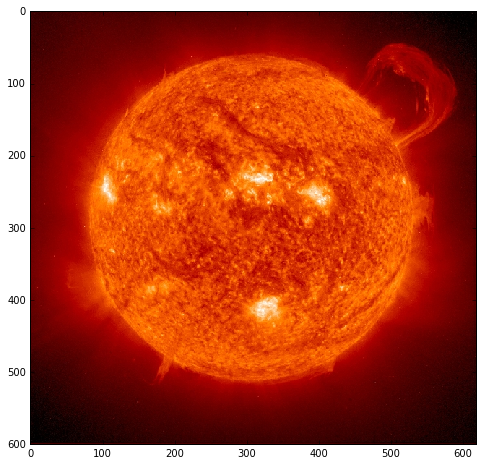

In [9]:
from skimage import io

image = io.imread('../../images/superprom_prev.jpg')

f, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image);

In this specific image, we got a bit more than we bargained for in the
form of magnificently large solar flares.  Let's see if some *canny
edge detection* will help isolate the sun's boundaries.

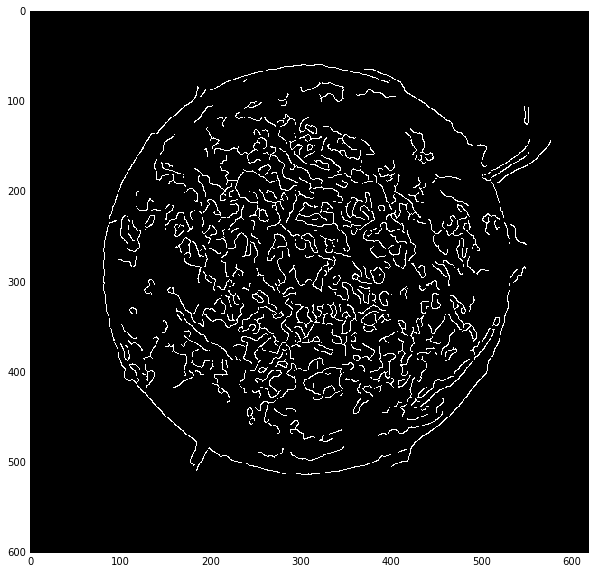

In [10]:
from skimage import feature, color

f, ax = plt.subplots(figsize=(10, 10))

edges = feature.canny(color.rgb2gray(image), sigma=2)
ax.imshow(edges, cmap='gray');

The edges look good, but there's a lot going on inside the sun.  We
use RANSAC to fit a robust circle model.

In [24]:
from skimage.measure import ransac, CircleModel

points = np.array(np.nonzero(edges)).T

model_robust, inliers = ransac(points, CircleModel, min_samples=3,
                               residual_threshold=2, max_trials=5000)

The parameters of the circle are center x, y and radius:

In [25]:
model_robust.params

array([ 286.9438398 ,  306.24049081,  225.61950888])

Let's visualize the results, drawing a circle on the sun, and also
highlighting inlier vs outlier edge pixels:

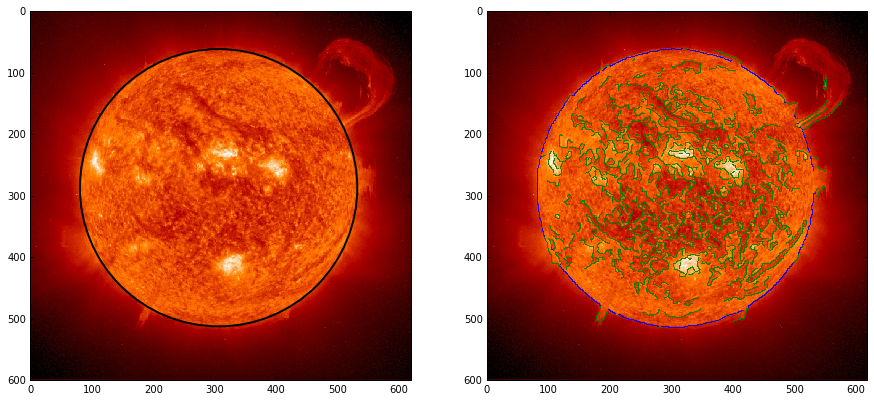

In [26]:
from skimage import draw

cy, cx, r = model_robust.params

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 8))

ax0.imshow(image)
ax1.imshow(image)

ax1.plot(points[inliers, 1], points[inliers, 0], 'b.', markersize=1)
ax1.plot(points[~inliers, 1], points[~inliers, 0], 'g.', markersize=1)
ax1.axis('image')

circle = plt.Circle((cx, cy), radius=r, facecolor='none', linewidth=2)
ax0.add_patch(circle);

The circular fit is, indeed, excellent, and rejects all the inner
squiggly edges generated by solar turbulence!

Note a general principle here: algorithms that aggregate across an
entire path are often robust against noise.  Here, we have *high
uncertainty* in the solar edge, but also know that only the solar edge
pixels contribute coherently to the full circular path around the
solar edge.

## Exercise: CardShark

Your small start-up, CardShark, run from your garage over nights and
evenings, takes photos of credit cards and turns them into machine
readable information.

The first step is to identify where in a photo the credit card is
located.

1. Load the photo `../../images/credit_card.jpg`
2. Using RANSAC and LineModelND shown above, find the first most
   prominent edge of the card
3. Remove the datapoints belonging to the most prominent edge, and
   repeat the process to find the second, third, and fourth

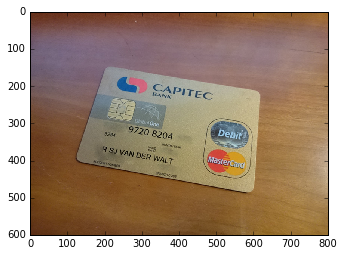

In [30]:
f, ax = plt.subplots()

image = io.imread('../../images/credit_card.jpg')
ax.imshow(image);

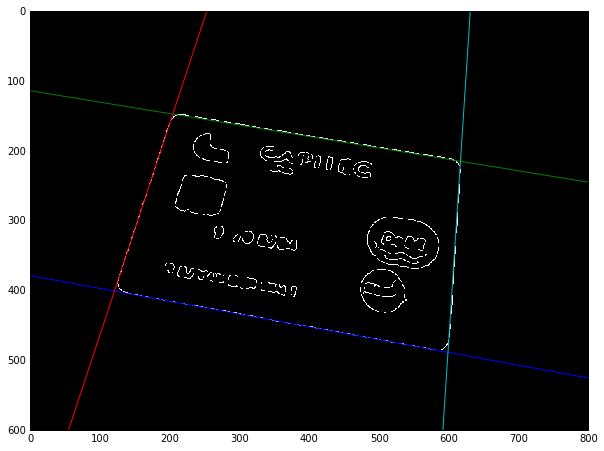

In [31]:
from skimage.measure import LineModelND

f, ax = plt.subplots(figsize=(10, 10))

edges = feature.canny(color.rgb2gray(image), sigma=3)
edge_pts = np.array(np.nonzero(edges), dtype=float).T
edge_pts_xy = edge_pts[:, ::-1]

for i in range(4):
    model_robust, inliers = ransac(edge_pts_xy, LineModelND, min_samples=2,
                                   residual_threshold=1, max_trials=1000)

    x = np.arange(800)
    plt.plot(x, model_robust.predict_y(x))

    edge_pts_xy = edge_pts_xy[~inliers]

plt.imshow(edges);